In [7]:
from unet_model import *
from glob import glob
import random
import matplotlib.pyplot as plt

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_path = glob('data/leftImg8bit/train/*/*leftImg8bit.png')
val_path = glob('data/leftImg8bit/val/*/*leftImg8bit.png')

model = UNet(3).float().to(device)
checkpoint = torch.load('weights/unetsegment_final.pt')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


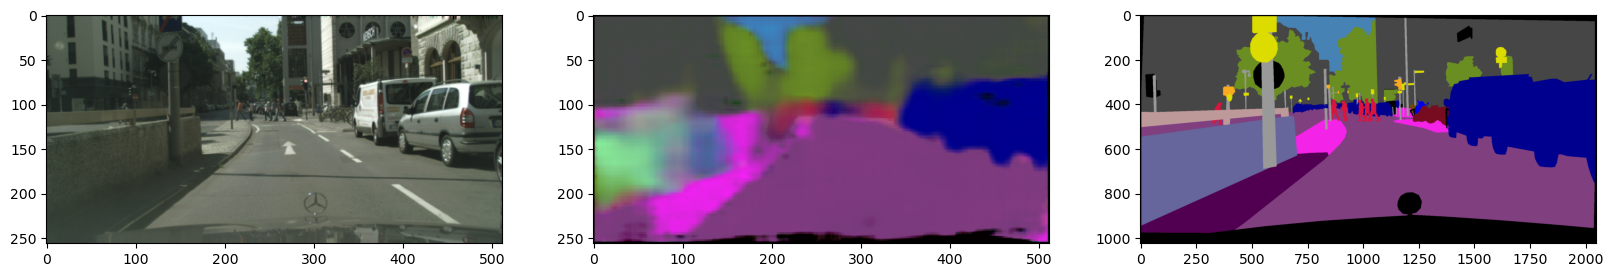

In [52]:

img_path = random.choice(val_path)
label_path = img_path.replace("leftImg8bit", "gtFine").replace(".png", "_color.png")
img = plt.imread(img_path)
label = plt.imread(label_path)
h, w = img.shape[:2]

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((h//4, w//4), antialias=True),
    #transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
])

img_in = transform(img).to(device)[None]
output = model(img_in).cpu().detach()[0].numpy().transpose(1, 2, 0)
img_in = img_in.cpu().detach()[0].numpy().transpose(1, 2, 0)

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
ax[0].imshow(img_in)
ax[1].imshow(output)
ax[2].imshow(label)
plt.show()